C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training Vanilla RNN model...
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0111 - val_loss: 3.5468e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0015 - val_loss: 3.8846e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5462e-04 - val_loss: 2.9823e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 4.5050e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0010 - val_loss: 5.5556e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0741e-04 - val_loss: 2.6012e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0015 - val_loss: 2.4493e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 3.1504e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0017 - val_loss: 2.3999e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 3.6863e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9485e-04 

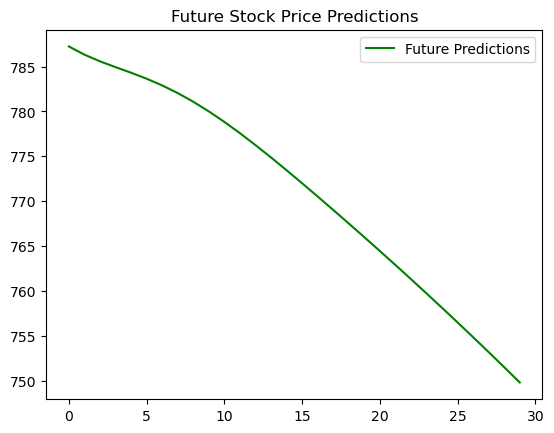

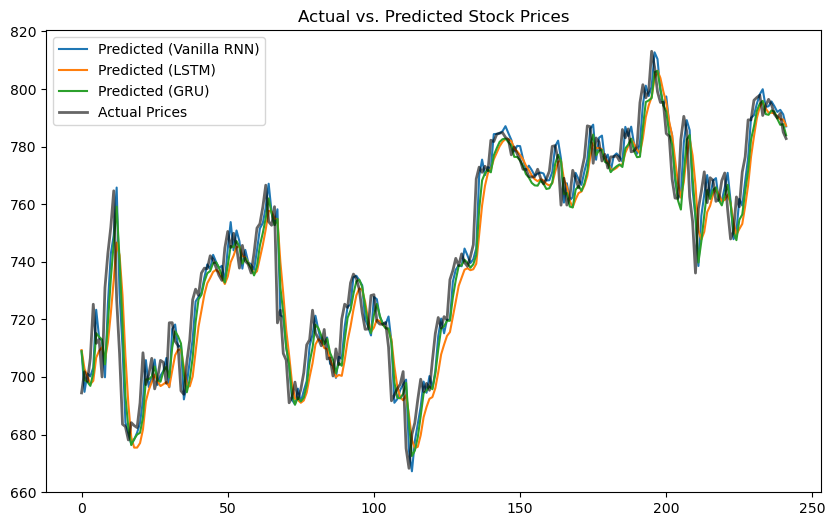

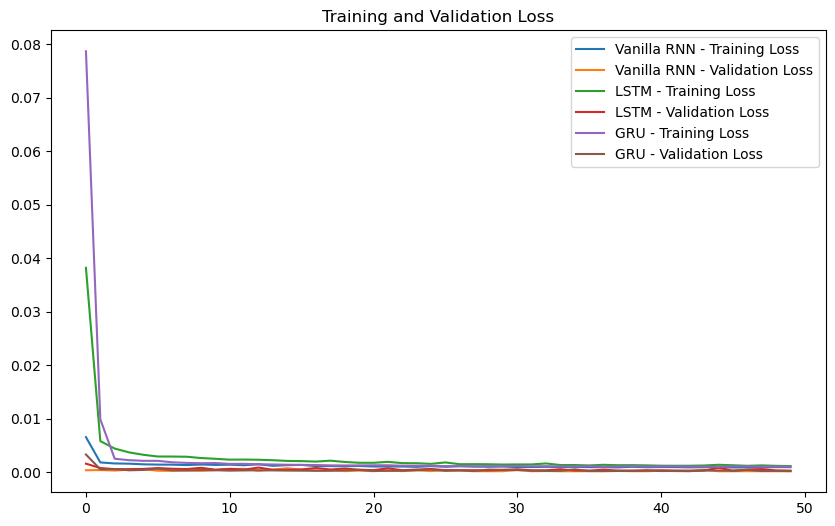

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.metrics import mean_squared_error

# 1. Load the Dataset
data = pd.read_csv("./Google_Stock_Price_Train.csv")
# 2. cleaning data to make the prediction more accurate and make easy to do operations on 'close' column's data by Removing commas and convert 'Close' column to float
data['Close'] = data['Close'].replace(',', '', regex=True).astype(float)
if data['Close'].isnull().sum() > 0:
    data['Close'].fillna(data['Close'].mean(), inplace=True)

# Normalizing the 'Close' column
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']].values)
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

# Define the number of input and output steps
n_steps_in = 50  
n_steps_out = 1

# Create sequences
X, y = create_sequences(scaled_data, n_steps_in, n_steps_out)

# Split training dataset into training and validation datasets
split_index = int(0.8 * len(X))  # 80% for training, 20% for validation
X_train, y_train = X[:split_index], y[:split_index]
X_val, y_val = X[split_index:], y[split_index:]

# Vanilla RNN Model
def build_rnn_model():
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=(n_steps_in, 1)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=(n_steps_in, 1)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

#GRU Model
def build_gru_model():
    model = Sequential([
        GRU(50, activation='tanh', input_shape=(n_steps_in, 1)),
        Dense(n_steps_out)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# 7. training and evaluating the Models
def train_and_evaluate_model(model, model_name):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=1
    )
    return history, model
models = {
    'Vanilla RNN': build_rnn_model(),
    'LSTM': build_lstm_model(),
    'GRU': build_gru_model()
}
histories = {}
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")
    history, trained_model = train_and_evaluate_model(model, name)
    histories[name] = history
    predictions[name] = trained_model.predict(X_val)

# 9.  Predictions for future price of stocks
def forecast_future(model, last_sequence, n_steps_ahead):
    forecast = []
    current_sequence = last_sequence
    for _ in range(n_steps_ahead):
        pred = model.predict(current_sequence.reshape(1, n_steps_in, 1))[0]
        forecast.append(pred)
        current_sequence = np.append(current_sequence[1:], pred)  # Shift window
    return np.array(forecast)
# taking 30 days as time for which to predict price
future_predictions = forecast_future(models['LSTM'], X_val[-1], 30)
future_predictions_rescaled = scaler.inverse_transform(future_predictions.reshape(-1, 1))
plt.plot(range(30), future_predictions_rescaled, label="Future Predictions", color="green")
plt.title("Future Stock Price Predictions")
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
for name, pred in predictions.items():
    pred_rescaled = scaler.inverse_transform(pred.reshape(-1, 1))
    plt.plot(pred_rescaled, label=f"Predicted ({name})")
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
plt.plot(y_val_rescaled, label="Actual Prices", color="black", linewidth=2, alpha=0.6)
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f"{name} - Training Loss")
    plt.plot(history.history['val_loss'], label=f"{name} - Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()




In [2]:
# 13. Evaluate Model Performance
def evaluate_model(y_true, y_pred, model_name):
    y_true_flat = y_true.reshape(-1, 1)
    y_pred_flat = y_pred.reshape(-1, 1)
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    print(f"Model: {model_name} | MSE: {mse:.4f}")
    return mse

for name, pred in predictions.items():
    pred_rescaled = scaler.inverse_transform(pred.reshape(-1, 1))
    y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1, 1))
    mse = evaluate_model(y_val_rescaled, pred_rescaled, name)


Model: Vanilla RNN | MSE: 84.4571
Model: LSTM | MSE: 147.9238
Model: GRU | MSE: 103.1977


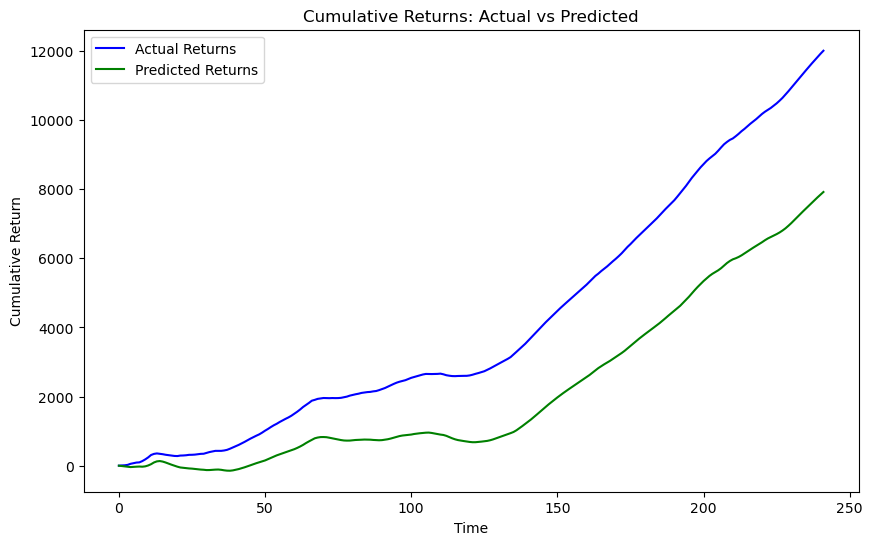

In [3]:

actual_returns = np.cumsum(y_val_rescaled - y_val_rescaled[0]) 
predicted_returns = np.cumsum(pred_rescaled - pred_rescaled[0]) 
plt.figure(figsize=(10, 6))
plt.plot(actual_returns, label="Actual Returns", color='blue')
plt.plot(predicted_returns, label="Predicted Returns", color='green')
plt.title('Cumulative Returns: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()
